In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("RegresiUTSTelkom.csv")
df = df.dropna()

In [8]:
# Target kolom: kolom pertama bertipe int
target_col = df.select_dtypes(include='int').columns[0]

# Feature selection berbasis korelasi
correlation = df.corr(numeric_only=True)[target_col].sort_values(ascending=False)
selected_features = correlation[abs(correlation) > 0.1].index.tolist()
selected_features.remove(target_col)

# Tentukan fitur dan target
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
X = df[selected_features + cat_cols]
y = df[target_col]

# Preprocessing
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

In [9]:
# 2. TENSORFLOW IMPLEMENTATION
# ----------------------------
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

def build_tf_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64, kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(1)
    ])
    return model

lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=10,
    t_mul=2.0,
    m_mul=0.9
)

optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-4)
model_tf = build_tf_model(X_train.shape[1])
model_tf.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model_tf.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step - loss: 3601126.0000 - mae: 1892.4438 - val_loss: 2128730.2500 - val_mae: 1452.8397
Epoch 2/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 1322077.7500 - mae: 1103.0078 - val_loss: 334708.1875 - val_mae: 556.2964
Epoch 3/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 108s 11ms/step - loss: 147085.1562 - mae: 308.2873 - val_loss: 3031.6804 - val_mae: 44.1721
Epoch 4/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 116s 11ms/step - loss: 40604.9023 - mae: 157.6001 - val_loss: 2967.7539 - val_mae: 44.7562
Epoch 5/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 110s 11ms/step - loss: 39699.7461 - mae: 155.6393 - val_loss: 4293.1133 - val_mae: 55.7236
Epoch 6/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/step - loss: 36878.6094 - mae: 150.6271 - val_loss: 4279.0620 - val_mae: 53.1135
Epoch 7/100
10307/10307 ━━━━━━━━━━━━━━━━━━━━ 108s 10ms/step - loss: 35863.6914 - mae: 148.9015 - val_loss: 4713.8682 - val_mae: 58.1998
Epoch 8/100
10307/10307 ━━━━━━━━━━━━━

3221/3221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 330.4146 - mae: 16.7905

TensorFlow - Test Loss: 330.2848, MAE: 16.7840
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 3s 783us/step
TensorFlow - MSE: 330.2845, RMSE: 18.1737, R2: -1.7828


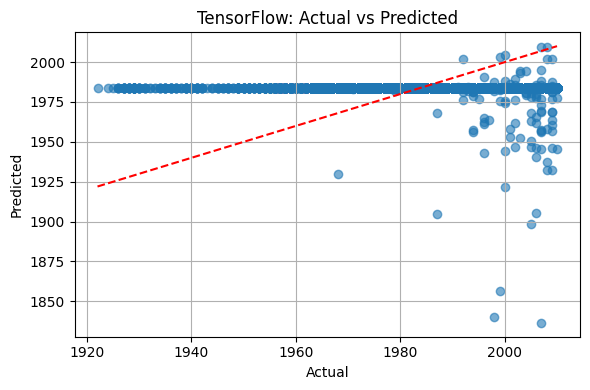

In [10]:
# Evaluasi
loss_tf, mae_tf = model_tf.evaluate(X_test, y_test)
print(f"\nTensorFlow - Test Loss: {loss_tf:.4f}, MAE: {mae_tf:.4f}")

# Prediksi dan evaluasi matriks
preds_tf = model_tf.predict(X_test).flatten()
mse_tf = mean_squared_error(y_test, preds_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, preds_tf)
print(f"TensorFlow - MSE: {mse_tf:.4f}, RMSE: {rmse_tf:.4f}, R2: {r2_tf:.4f}")

# Visualisasi
plt.figure(figsize=(6, 4))
plt.scatter(y_test, preds_tf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("TensorFlow: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# 3. PYTORCH IMPLEMENTATION
# -------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Arsitektur MLP PyTorch
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Konversi data ke tensor
X_train_tensor = torch.tensor(X_train.toarray() if hasattr(X_train, "toarray") else X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.toarray() if hasattr(X_test, "toarray") else X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model, Optimizer, Scheduler
model_pt = MLPRegressor(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_pt.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Training loop dengan early stopping
best_loss = float('inf')
patience = 10
counter = 0

for epoch in range(100):
    model_pt.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_pt(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    scheduler.step()

    model_pt.eval()
    with torch.no_grad():
        val_preds = model_pt(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor)

    print(f"Epoch {epoch+1}, Val Loss: {val_loss.item():.4f}")

Epoch 1, Val Loss: 3105.0498
Epoch 2, Val Loss: 3110.0012
Epoch 3, Val Loss: 3902.9602
Epoch 4, Val Loss: 2150.1414
Epoch 5, Val Loss: 4531.4956
Epoch 6, Val Loss: 3379.3445
Epoch 7, Val Loss: 1277.4879
Epoch 8, Val Loss: 829.0414
Epoch 9, Val Loss: 823.4484
Epoch 10, Val Loss: 786.0257
Epoch 11, Val Loss: 253.9041
Epoch 12, Val Loss: 250.6536
Epoch 13, Val Loss: 295.2322
Epoch 14, Val Loss: 458.6270
Epoch 15, Val Loss: 377.8664
Epoch 16, Val Loss: 385.5711
Epoch 17, Val Loss: 381.7224
Epoch 18, Val Loss: 270.4529
Epoch 19, Val Loss: 298.5266
Epoch 20, Val Loss: 285.9774
Epoch 21, Val Loss: 257.2388
Epoch 22, Val Loss: 269.8391
Epoch 23, Val Loss: 263.6680
Epoch 24, Val Loss: 270.3072
Epoch 25, Val Loss: 241.2887
Epoch 26, Val Loss: 246.9427
Epoch 27, Val Loss: 245.9141
Epoch 28, Val Loss: 265.6787
Epoch 29, Val Loss: 263.6767
Epoch 30, Val Loss: 262.0169
Epoch 31, Val Loss: 504.2224
Epoch 32, Val Loss: 430.5552
Epoch 33, Val Loss: 295.5898
Epoch 34, Val Loss: 166.7967
Epoch 35, Val Lo


PyTorch - MSE: 268.8389, RMSE: 16.3963, R2: -1.2651


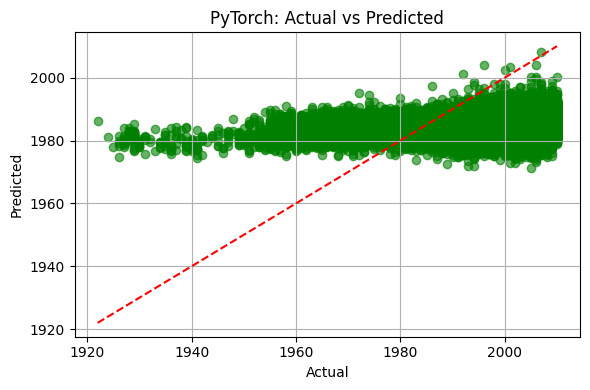


Matriks Evaluasi:
- MSE (Mean Squared Error): memberikan penalti lebih besar pada error besar, bagus untuk deteksi error besar.
- RMSE (Root MSE): mirip MSE tapi satuan sama dengan target, interpretasi lebih mudah.
- R2 (R-squared): menunjukkan seberapa baik model menjelaskan variasi data, makin dekat 1 makin baik.

Biasanya, RMSE digunakan untuk interpretasi error, dan R2 untuk mengukur goodness-of-fit.


In [12]:
# Evaluasi akhir
model_pt.eval()
with torch.no_grad():
    test_preds_pt = model_pt(X_test_tensor).numpy().flatten()
    test_loss = criterion(torch.tensor(test_preds_pt).view(-1,1), y_test_tensor)
    mse_pt = mean_squared_error(y_test, test_preds_pt)
    rmse_pt = np.sqrt(mse_pt)
    r2_pt = r2_score(y_test, test_preds_pt)
    print(f"\nPyTorch - MSE: {mse_pt:.4f}, RMSE: {rmse_pt:.4f}, R2: {r2_pt:.4f}")

# Visualisasi PyTorch
plt.figure(figsize=(6, 4))
plt.scatter(y_test, test_preds_pt, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("PyTorch: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Penjelasan Matriks Evaluasi
print("\nMatriks Evaluasi:")
print("- MSE (Mean Squared Error): memberikan penalti lebih besar pada error besar, bagus untuk deteksi error besar.")
print("- RMSE (Root MSE): mirip MSE tapi satuan sama dengan target, interpretasi lebih mudah.")
print("- R2 (R-squared): menunjukkan seberapa baik model menjelaskan variasi data, makin dekat 1 makin baik.")
print("\nBiasanya, RMSE digunakan untuk interpretasi error, dan R2 untuk mengukur goodness-of-fit.")

# 📊 Evaluasi Model MLP Setelah Feature Selection

## ✅ TensorFlow Model

**Evaluasi:**
- **MSE:** 330.2845  
- **RMSE:** 18.1737  
- **MAE:** 16.7840  
- **R²:** -1.7828 ❌

---

## ✅ PyTorch Model

**Evaluasi:**
- **MSE:** 268.8389  
- **RMSE:** 16.3963  
- **R²:** -1.2651 ❌

---

## 📌 Penjelasan Metrik Evaluasi

- **MSE (Mean Squared Error):** Memberikan penalti lebih besar pada error besar. Cocok untuk mendeteksi kesalahan besar.
- **RMSE (Root Mean Squared Error):** Akar kuadrat dari MSE, memiliki satuan yang sama dengan target. Lebih mudah diinterpretasi.
- **MAE (Mean Absolute Error):** Rata-rata kesalahan absolut. Lebih tahan terhadap outlier.
- **R² (R-squared):** Mengukur seberapa baik model menjelaskan variasi data. Nilai 1 artinya sempurna. Nilai negatif berarti lebih buruk dari prediksi rata-rata.

---

## 🧠 Analisa dan Kesimpulan

| Model        | MSE     | RMSE    | R²       |
|--------------|---------|---------|----------|
| TensorFlow   | 330.28  | 18.17   | -1.7828  |
| PyTorch      | 268.83  | 16.39   | -1.2651  |

### 🔍 Analisa:
- Kedua model menunjukkan **kinerja yang buruk** (R² < 0), menandakan **underfitting**.
- Model PyTorch memiliki hasil **lebih baik di semua metrik**, walau masih belum ideal.
- Feature selection kemungkinan **terlalu menyederhanakan input**, menyebabkan hilangnya informasi penting.
- Arsitektur atau konfigurasi model perlu **diperkuat atau dioptimalkan lebih lanjut**.

### ✅ **Model Terbaik: PyTorch**
> Karena menghasilkan nilai **MSE, RMSE, dan R²** yang lebih baik dibanding TensorFlow meskipun masih perlu perbaikan.

---

## 🚧 Rekomendasi Perbaikan

- Gunakan **model-based feature selection** (Random Forest, Lasso).
- Terapkan **transformasi target** seperti log-scaling jika distribusi target skewed.
- Periksa dan tangani **outlier** ekstrem di data.
- Eksperimen dengan model lain seperti **XGBoost, LightGBM, atau Random Forest Regressor**.
- Tambahkan fitur baru dari domain knowledge bila memungkinkan.
